In [1]:
# DS
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# GDS
import geopandas as gpd
import contextily as ctx
from shapely import wkt

# network
import networkx as nx
import powerlaw

from my_utils import *

In [2]:
print(VERSION)

v3.0


# Network 

In [4]:
df_tf_odRegion = pd.read_csv(f"result/df_tf_odRegion_{VERSION}.csv")
gdf_zoning = read_csv_to_gdf(f"result/gdf_zoning_{VERSION}.csv").to_crs("epsg:2263")
df_zonevec = pd.read_csv(f"result/df_zonevec_{VERSION}.csv")

In [9]:
ids = set(df_zonevec.id.values) & set(df_tf_odRegion.Destiny_ID.unique()) & set(df_tf_odRegion.Origin_ID.unique())
dict_mapids = {x:i for i,x in enumerate(ids)}

In [5]:
# map to new regin id
df_tf_odRegionN = df_tf_odRegion.copy()
df_tf_odRegionN["Origin_ID"] = df_tf_odRegionN["Origin_ID"].apply(lambda x:dict_mapids[x] if x in dict_mapids.keys() else -1)
df_tf_odRegionN["Destiny_ID"] = df_tf_odRegionN["Destiny_ID"].apply(lambda x:dict_mapids[x] if x in dict_mapids.keys() else -1)

# drop invalid regions
df_tf_odRegionN = df_tf_odRegionN[(df_tf_odRegionN["Origin_ID"]!=-1).values & (df_tf_odRegionN["Destiny_ID"]!=-1).values] \
                    .reset_index(drop=True)

In [45]:
len(df_tf_odRegionN),len(df_tf_odRegion)

(12252985, 12637248)

In [98]:
# df_tf_odRegionN = df_tf_odRegionN.assign(time= lambda x:(x["dayofmonth"]-1)*24+x["hour"]+1)

In [100]:
df_tf_odRegionN = df_tf_odRegionN.assign(time= lambda x:(x["weekend"])*24+x["hour"]+1)

In [102]:
df_flowcount = pd.pivot_table(df_tf_odRegionN[['Origin_ID', 'Destiny_ID', 'time','pasg']],
                              values='pasg', index=['Origin_ID', 'Destiny_ID'],
                              columns='time', aggfunc=np.sum) \
                .fillna(0) \
                .astype(int)

In [103]:
df_flowcount.head(5)

time                  1   2   3   4   5   6   7   8   9   10  ...  39  40  41  \
Origin_ID Destiny_ID                                          ...               
0         1975         0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
1         2220         0   0   0   0   0   0   0   1   0   0  ...   0   0   0   
2         2            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
          995          0   0   0   0   0   0   0   0   0   0  ...   0   0   0   
          2220         0   0   0   0   0   0   2   0   0   0  ...   0   0   0   

time                  42  43  44  45  46  47  48  
Origin_ID Destiny_ID                              
0         1975         0   0   0   0   0   0   0  
1         2220         0   0   0   0   0   0   0  
2         2            0   0   0   0   0   0   0  
          995          0   0   0   0   0   0   0  
          2220         0   0   0   0   0   0   0  

[5 rows x 48 columns]

In [104]:
index_tobeadd = set((i,i) for i in dict_mapids.values()) - set(df_flowcount.index)
index_tobeadd = np.array([list(i) for i in index_tobeadd])
df_flow_tobeadd = pd.DataFrame(columns = [i+1 for i in range(48)], 
                               index = pd.MultiIndex.from_arrays(np.array(index_tobeadd).T, 
                                                                 names=('Origin_ID', 'Destiny_ID'))) \
                    .fillna(0)

df_flowcount_filled = pd.concat([df_flowcount,df_flow_tobeadd]).sort_index()

In [117]:
df_flowcount_filled.to_csv(f"result/df_flowcount_filled_{VERSION}.csv")

## Freq

In [35]:
df_flowcount_filled = pd.read_csv(f"result/df_flowcount_filled_{VERSION}.csv").set_index(['Origin_ID', 'Destiny_ID'])

In [17]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
 
def fourier(x, *a):
    w = 2 * np.pi / 48
    ret = 0
    for deg in range(0, int(len(a) / 2) + 1):
        ret += a[deg] * np.cos(deg * w * x) + a[len(a) - deg - 1] * np.sin(deg * w * x)
    return ret

def fft(y):
    x = np.arange(1,49,1)
    popt, pcov = curve_fit(fourier, x, y, [1.0] * 20)
    return popt.round(5)

In [135]:
dic = {}
for i,row in tqdm.tqdm(df_flowcount_filled.iterrows()):
    dic[i] = fft(row.values)

505766it [59:07, 142.58it/s]


In [140]:
df_edges = pd.DataFrame.from_dict(dic).T

In [141]:
df_edges.to_csv(f"result/df_edges_{VERSION}.csv")

In [136]:
np.save("result/dic",dic)

## fft back

In [43]:
efeats[idx]

array([23.54167, -6.73017,  0.17043, -4.97363,  3.70264,  2.8315 ,
        6.4379 , -0.68115, -2.33333, -1.41855, -1.0891 ,  0.21651,
        5.15297,  3.1297 , -2.56709, -4.15799, -2.05386, -6.30115,
       13.17348,  1.     ])

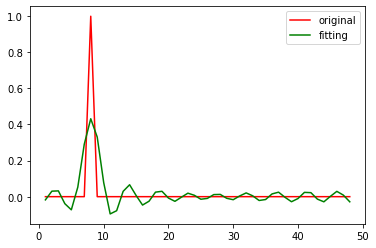

In [49]:
idx = -11

y = df_flowcount_filled.iloc[idx]
x = np.arange(1,49,1)
# popt, pcov = curve_fit(fourier, x, y, [1.0] * 20)
plt.plot(x, y, color='r', label="original")
plt.plot(x, fourier(x, *efeats[idx]), color='g', label="fitting")
plt.legend()
plt.show()

* 两种思路 时序预测
* 时序特征提取

## Network

In [3]:
df_tf_odRegion = pd.read_csv(f"result/df_tf_odRegion_{VERSION}.csv")
gdf_zoning = read_csv_to_gdf(f"result/gdf_zoning_{VERSION}.csv").to_crs("epsg:2263")
df_zonevec = pd.read_csv(f"result/df_zonevec_{VERSION}.csv")

ids = set(df_zonevec.id.values) & set(df_tf_odRegion.Destiny_ID.unique()) & set(df_tf_odRegion.Origin_ID.unique())
dict_mapids = {x:i for i,x in enumerate(ids)}

In [4]:
df_edges = pd.read_csv(f"result/df_edges_{VERSION}.csv").set_index(['Unnamed: 0', 'Unnamed: 1'])

In [5]:
df_zonevec["new_id"] = df_zonevec["id"].apply(lambda x:dict_mapids[x] if x in dict_mapids.keys() else -1)

In [6]:
df_zonevecN = df_zonevec[df_zonevec.new_id!=-1].drop("id",axis=1).set_index("new_id").sort_index()

In [7]:
edges = [list(i) for i in df_edges.index]
nodes = [i for i in range(len(dict_mapids))]

In [8]:
from collections import defaultdict

edgeid_to_idx = defaultdict(set)
adj_lists = defaultdict(set)

for i,e in enumerate(edges):
    edgeid_to_idx[tuple(e)] = i
    u,v =e
    adj_lists[u].add(v)

In [9]:
nfeats = np.array(df_zonevecN.loc[:,[f"ZoneVec_{i+1}" for i in range(20)]])

In [10]:
efeats = df_edges.values

## Train

In [11]:
from model.GraphSAGE import *
import torch
import math
from sklearn.utils import shuffle

device = torch.device("cpu")
nfeats1 = torch.tensor(nfeats).float().to(device)
efeats1 = torch.tensor(efeats).float().to(device)
nodes = nodes

In [12]:
args = {"seed":43,
        "num_layers":2,
        "batch_size":10,
        "num_neg":10,
        "num_epochs":50,
        "lr":0.5,
        "input_dim":60,
        "output_dim":20}

random.seed(args["seed"])
np.random.seed(args["seed"])
torch.manual_seed(args["seed"])

graphSage = GraphSage(args["input_dim"],  # agg_feature_dim
                      args["output_dim"],  # node_hidden_dim
                      nfeats1,
                      efeats1,
                      adj_lists, 
                      edgeid_to_idx,
                      device)
graphSage.to(device)

unsupervised_loss = UnsupervisedLoss(adj_lists, nodes , device)

for epoch in range(args["num_epochs"]):
    print('----------------------EPOCH %d-----------------------' % epoch)
    train_nodes = shuffle(nodes)
    models = [graphSage]
    params = []
    for model in models:
        for param in model.parameters():
            if param.requires_grad:
                params.append(param)

    optimizer = torch.optim.SGD(params, lr=args["lr"])
    optimizer.zero_grad()
    for model in models:
        model.zero_grad()
    
    batches = math.ceil(len(train_nodes) / args["batch_size"])
    visited_nodes = set()

    for index in range(batches):
        nodes_batch = np.array(train_nodes[index*args["batch_size"]:(index+1)*args["batch_size"]])
        
        # extend nodes batch for unspervised learning
        nodes_batch = np.asarray(list(unsupervised_loss.extend_nodes(nodes_batch, num_neg=args["num_neg"])))
        visited_nodes |= set(nodes_batch)
        
        embs_batch = graphSage(nodes_batch)
        loss = unsupervised_loss.get_loss_margin(embs_batch, nodes_batch)
        print('Step [{}/{}], Loss: {:.4f}, Dealed Nodes [{}/{}] '.format(index+1, batches, loss.item(), len(visited_nodes), len(train_nodes)))
        loss.backward()
        for model in models:
            nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        optimizer.zero_grad()
        for model in models:
            model.zero_grad()

----------------------EPOCH 0-----------------------
Step [1/271], Loss: 3.1430, Dealed Nodes [67/2709] 
Step [2/271], Loss: 3.1622, Dealed Nodes [119/2709] 
Step [3/271], Loss: 3.1044, Dealed Nodes [169/2709] 
Step [4/271], Loss: 3.0898, Dealed Nodes [218/2709] 
Step [5/271], Loss: 3.0458, Dealed Nodes [260/2709] 
Step [6/271], Loss: 3.0864, Dealed Nodes [296/2709] 
Step [7/271], Loss: 3.0985, Dealed Nodes [343/2709] 
Step [8/271], Loss: 3.0781, Dealed Nodes [385/2709] 
Step [9/271], Loss: 3.0628, Dealed Nodes [422/2709] 
Step [10/271], Loss: 3.0722, Dealed Nodes [458/2709] 
Step [11/271], Loss: 3.0797, Dealed Nodes [489/2709] 
Step [12/271], Loss: 3.0642, Dealed Nodes [528/2709] 
Step [13/271], Loss: 3.0691, Dealed Nodes [575/2709] 
Step [14/271], Loss: 3.0605, Dealed Nodes [606/2709] 
Step [15/271], Loss: 3.0628, Dealed Nodes [643/2709] 
Step [16/271], Loss: 3.0788, Dealed Nodes [678/2709] 
Step [17/271], Loss: 3.0473, Dealed Nodes [709/2709] 
Step [18/271], Loss: 3.0347, Dealed Nod

Step [149/271], Loss: 3.0106, Dealed Nodes [2320/2709] 
Step [150/271], Loss: 3.0136, Dealed Nodes [2324/2709] 
Step [151/271], Loss: 3.0072, Dealed Nodes [2334/2709] 
Step [152/271], Loss: 3.0091, Dealed Nodes [2341/2709] 
Step [153/271], Loss: 3.0105, Dealed Nodes [2348/2709] 
Step [154/271], Loss: 3.0095, Dealed Nodes [2352/2709] 
Step [155/271], Loss: 3.0087, Dealed Nodes [2356/2709] 
Step [156/271], Loss: 3.0123, Dealed Nodes [2360/2709] 
Step [157/271], Loss: 3.0092, Dealed Nodes [2368/2709] 
Step [158/271], Loss: 3.0110, Dealed Nodes [2374/2709] 
Step [159/271], Loss: 3.0105, Dealed Nodes [2377/2709] 
Step [160/271], Loss: 3.0100, Dealed Nodes [2380/2709] 
Step [161/271], Loss: 3.0066, Dealed Nodes [2386/2709] 
Step [162/271], Loss: 3.0097, Dealed Nodes [2389/2709] 
Step [163/271], Loss: 3.0092, Dealed Nodes [2392/2709] 
Step [164/271], Loss: 3.0156, Dealed Nodes [2396/2709] 
Step [165/271], Loss: 3.0146, Dealed Nodes [2404/2709] 
Step [166/271], Loss: 3.0169, Dealed Nodes [2407

Step [25/271], Loss: 3.0080, Dealed Nodes [930/2709] 
Step [26/271], Loss: 3.0078, Dealed Nodes [956/2709] 
Step [27/271], Loss: 2.9973, Dealed Nodes [985/2709] 
Step [28/271], Loss: 3.0014, Dealed Nodes [1011/2709] 
Step [29/271], Loss: 3.0075, Dealed Nodes [1027/2709] 
Step [30/271], Loss: 3.0017, Dealed Nodes [1049/2709] 
Step [31/271], Loss: 3.0029, Dealed Nodes [1072/2709] 
Step [32/271], Loss: 3.0081, Dealed Nodes [1095/2709] 
Step [33/271], Loss: 3.0095, Dealed Nodes [1115/2709] 
Step [34/271], Loss: 3.0001, Dealed Nodes [1134/2709] 
Step [35/271], Loss: 3.0011, Dealed Nodes [1160/2709] 
Step [36/271], Loss: 3.0228, Dealed Nodes [1180/2709] 
Step [37/271], Loss: 3.0054, Dealed Nodes [1192/2709] 
Step [38/271], Loss: 3.0055, Dealed Nodes [1218/2709] 
Step [39/271], Loss: 3.0099, Dealed Nodes [1238/2709] 
Step [40/271], Loss: 3.0066, Dealed Nodes [1252/2709] 
Step [41/271], Loss: 3.0092, Dealed Nodes [1271/2709] 
Step [42/271], Loss: 3.0002, Dealed Nodes [1283/2709] 
Step [43/271]

Step [173/271], Loss: 2.9962, Dealed Nodes [2435/2709] 
Step [174/271], Loss: 2.9955, Dealed Nodes [2439/2709] 
Step [175/271], Loss: 3.0027, Dealed Nodes [2444/2709] 
Step [176/271], Loss: 2.9906, Dealed Nodes [2454/2709] 
Step [177/271], Loss: 2.9897, Dealed Nodes [2458/2709] 
Step [178/271], Loss: 3.0014, Dealed Nodes [2463/2709] 
Step [179/271], Loss: 2.9894, Dealed Nodes [2467/2709] 
Step [180/271], Loss: 2.9947, Dealed Nodes [2469/2709] 
Step [181/271], Loss: 2.9937, Dealed Nodes [2472/2709] 
Step [182/271], Loss: 2.9867, Dealed Nodes [2481/2709] 
Step [183/271], Loss: 2.9906, Dealed Nodes [2483/2709] 
Step [184/271], Loss: 2.9963, Dealed Nodes [2487/2709] 
Step [185/271], Loss: 2.9947, Dealed Nodes [2493/2709] 
Step [186/271], Loss: 2.9875, Dealed Nodes [2495/2709] 
Step [187/271], Loss: 2.9977, Dealed Nodes [2498/2709] 
Step [188/271], Loss: 2.9928, Dealed Nodes [2502/2709] 
Step [189/271], Loss: 2.9897, Dealed Nodes [2504/2709] 
Step [190/271], Loss: 2.9969, Dealed Nodes [2506

KeyboardInterrupt: 

In [13]:
node_embeddings = model(nodes).detach().numpy()

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score,confusion_matrix,accuracy_score,cohen_kappa_score

node_subject = gdf_zoning.loc[dict_mapids.keys(),"zone_c"].astype("category").cat.codes

# X = node_embeddings
# if X.shape[1] > 2:
#     transform = TSNE  # PCA

#     trans = transform(n_components=2)
#     emb_transformed = pd.DataFrame(trans.fit_transform(X), index=NODES)
#     emb_transformed["lab"] = node_subject
# else:
#     emb_transformed = pd.DataFrame(X, index=node_ids)
#     emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
#     emb_transformed["lab"] = node_subject

df_gnnvec = pd.DataFrame(node_embeddings)
df_gnnvec["lab"] = node_subject
df_gnnvec.to_csv("result/torchgnn_vec.csv",index=False)

X = df_gnnvec[[i for i in range(20)]]
y = df_gnnvec.lab.astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

matrix = confusion_matrix(y_test, y_pred)
acc = matrix.diagonal()/matrix.sum(axis=1)
print(acc)
print(accuracy_score(y_test,y_pred))
print(cohen_kappa_score(y_test,y_pred))

[0.71818182 0.07594937 0.         0.         0.04347826 0.
 0.14285714 0.08888889]
0.34317343173431736
0.0278320804530523
